For this tutorial the following packages are required in addition to the `simframe` requirements:

* `astropy`
* `matplotlib`

In this tutorial you'll learn how to update groups and fields

# Updating Groups and Fields

In this example we revisit the orbital integration. But this time we also want to calculate the equilibrium temperature on Earth. That is not a quantity that we need to integrate. We can simply calculate it from the other quantities.

## Setting up the problem

The problem setup follows the previous example. Please have a lokk there for more details.

In [1]:
from simframe import Frame

In [2]:
sim = Frame(description="Sun-Earth system")

In [3]:
sim.addgroup("Sun")
sim.addgroup("Earth")

In [4]:
import astropy.constants as c
import astropy.units as u

In [5]:
AU   = (1.*u.au).si.value
day  = (1.*u.day).si.value
G    = c.G.si.value
year = (1.*u.year).si.value

M_earth = c.M_earth.si.value
M_sun   = c.M_sun.si.value

### Earth

In [6]:
sim.Earth.addfield("M", M_earth, description="Mass [kg]", constant=True)

In [7]:
import numpy as np

In [8]:
sim.Earth.addfield("r", np.zeros(3), description="Position [m]")
sim.Earth.addfield("v", np.zeros(3), description="Velocity [m/s]")

### Sun

In [9]:
sim.Sun.addfield("M", c.M_sun.si.value, description="Mass [kg]", constant=True)
sim.Sun.addfield("r", np.zeros(3), description="Position [m]")
sim.Sun.addfield("v", np.zeros(3), description="Velocity [m/s]")

### Integration variable

In [10]:
sim.addintegrationvariable("t", 0., description="Time [s]")

In [11]:
dt = 1.*day

In [12]:
def f_dt(sim):
    return dt

In [13]:
sim.t.updater = f_dt

In [14]:
snapwidth = 5.*day
tmax = 2.*year

In [15]:
sim.t.snapshots = np.arange(snapwidth, tmax+1, snapwidth)

### Writer

In [16]:
from simframe import writers

In [17]:
sim.writer = writers.hdf5writer

In [18]:
sim.writer.datadir = "3_data"
sim.writer.overwrite = True

### Differential equations

In [19]:
def dr_Earth(sim, x, Y):
    return sim.Earth.v

def dr_Sun(sim, x, Y):
    return sim.Sun.v

In [20]:
# Gravitational acceleration
def ag(M, r, R):
    direction = r-R
    distance = np.linalg.norm(direction)
    return -G * M * direction / distance**3

In [21]:
def dv_Earth(sim, x, Y):
    return ag(sim.Sun.M, sim.Earth.r, sim.Sun.r)

def dv_Sun(sim, x, Y):
    return ag(sim.Earth.M, sim.Sun.r, sim.Earth.r)

In [22]:
sim.Earth.v.differentiator = dv_Earth
sim.Earth.r.differentiator = dr_Earth
sim.Sun.v.differentiator   = dv_Sun
sim.Sun.r.differentiator   = dr_Sun

### Integrator

In [23]:
from simframe import Integrator

In [24]:
integrator = Integrator(sim.t, description="Leapfrog orbital integration")

In [25]:
from simframe import schemes
from simframe.integration import Instruction

### Leapfrog integrator

In [26]:
instructions = [Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
                Instruction(schemes.update,       sim.Sun.v             ),
                Instruction(schemes.update,       sim.Earth.v           ),
                Instruction(schemes.expl_1_euler, sim.Sun.r,   fstep=1.0),
                Instruction(schemes.expl_1_euler, sim.Earth.r, fstep=1.0),
                Instruction(schemes.update,       sim.Sun.r             ),
                Instruction(schemes.update,       sim.Earth.r           ),
                Instruction(schemes.expl_1_euler, sim.Sun.v,   fstep=0.5),
                Instruction(schemes.expl_1_euler, sim.Earth.v, fstep=0.5),
               ]

In [27]:
integrator.instructions = instructions

In [28]:
sim.integrator = integrator

## Initial conditions

In this example we want to send the Earth on an eccentric orbit to have a seasonal changing equilibrium temperature. For this we simply incline the initial velocities of Earth an Sun by an angle `alpha`.

In [29]:
r_Earth_ini = np.array([AU, 0., 0.])
r_Sun_ini = np.zeros(3)
# Center of mass
COM_ini = (M_earth*r_Earth_ini + M_sun*r_Sun_ini) / (M_earth+M_sun)
# Offset both positions
r_Earth_ini -= COM_ini
r_Sun_ini -= COM_ini

In [30]:
mu = M_earth*M_sun / (M_earth+M_sun)

In [31]:
alpha = 30. * u.deg
v_Earth_ini = np.sqrt(G*M_sun/M_earth*mu/AU)
v_Earth_ini = np.array([-np.sin(alpha)*v_Earth_ini, np.cos(alpha)*v_Earth_ini, 0.])
v_Sun_ini   = np.sqrt(G*M_earth/M_sun*mu/AU)
v_Sun_ini   = np.array([np.sin(alpha)*v_Sun_ini, -np.cos(alpha)*v_Sun_ini, 0.])

In [32]:
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini

### Starting

In [33]:
sim.run()

Creating data directory '3_data'.
Writing file '3_data/data0000.hdf5'
Writing file '3_data/data0001.hdf5'
Writing file '3_data/data0002.hdf5'
Writing file '3_data/data0003.hdf5'
Writing file '3_data/data0004.hdf5'
Writing file '3_data/data0005.hdf5'
Writing file '3_data/data0006.hdf5'
Writing file '3_data/data0007.hdf5'
Writing file '3_data/data0008.hdf5'
Writing file '3_data/data0009.hdf5'
Writing file '3_data/data0010.hdf5'
Writing file '3_data/data0011.hdf5'
Writing file '3_data/data0012.hdf5'
Writing file '3_data/data0013.hdf5'
Writing file '3_data/data0014.hdf5'
Writing file '3_data/data0015.hdf5'
Writing file '3_data/data0016.hdf5'
Writing file '3_data/data0017.hdf5'
Writing file '3_data/data0018.hdf5'
Writing file '3_data/data0019.hdf5'
Writing file '3_data/data0020.hdf5'
Writing file '3_data/data0021.hdf5'
Writing file '3_data/data0022.hdf5'
Writing file '3_data/data0023.hdf5'
Writing file '3_data/data0024.hdf5'
Writing file '3_data/data0025.hdf5'
Writing file '3_data/data0026.

### Reading and plotting

In [34]:
data = sim.writer.read.all()

In [35]:
import matplotlib.pyplot as plt
width = 2.
dpi = 300

def plot_orbits(data):
    fig, ax = plt.subplots(figsize=(width, width), dpi=dpi)
    ax.set_aspect(1)
    ax.axis("off")
    fig.set_facecolor("#000000")
    imax = data.t.shape[0]
    for i in range(imax):
        alpha = np.maximum(i/imax-0.2, 0.2)
        ax.plot(data.Sun.r[i, 0], data.Sun.r[i, 1], "o", c="#FFFF00", markersize=2, alpha=alpha)
        ax.plot(data.Earth.r[i, 0], data.Earth.r[i, 1], "o", c="#0000FF", markersize=0.5, alpha=alpha)
    ax.plot(data.Sun.r[-1, 0], data.Sun.r[-1, 1], "o", c="#FFFF00", markersize=8)
    ax.plot(data.Earth.r[-1, 0], data.Earth.r[-1, 1], "o", c="#0000FF", markersize=2)
    ax.set_xlim(-2.*AU, 2.*AU)
    ax.set_ylim(-2.*AU, 2.*AU)
    fig.tight_layout()

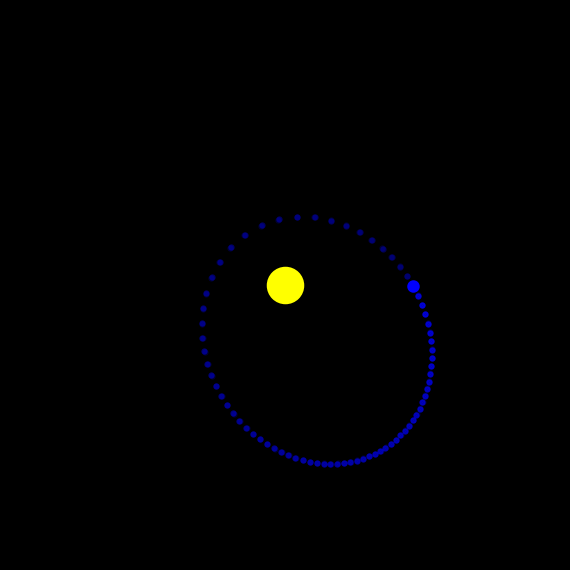

In [36]:
plot_orbits(data)

## Adding Temperature

To calculate the temperature Earth and Sun need additional fields for their temperatures and their radii. In additional to that, we give the Earth an additional field for the Earth-Sun distance.

In [37]:
R_Earth = c.R_earth.si.value
R_Sun   = c.R_sun.si.value

We initialize the Earth's temperature with zero and update it as soon as we have a function for it.

In [38]:
sim.Earth.addfield("d", AU, description="Earth-Sun distance [m]")
sim.Earth.addfield("R", R_Earth, description="Radius [m]")
sim.Earth.addfield("T", 0., description="Temperature [K]")

In [39]:
sim.Earth

Group
-----
    d            : Field (Earth-Sun distance [m])
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    R            : Field (Radius [m])
    T            : Field (Temperature [K])
    v            : Field (Velocity [m/s])
  -----

In [40]:
sim.Sun.addfield("R", R_Sun, description="Radius [m]", constant=True)
sim.Sun.addfield("T", 5778, description="Effective temperature [K]", constant=True)

In [41]:
sim.Sun

Group
-----
    M            : Field (Mass [kg]), constant
    r            : Field (Position [m])
    R            : Field (Radius [m]), constant
    T            : Field (Effective temperature [K]), constant
    v            : Field (Velocity [m/s])
  -----

The function for calculating the Earth-Sun distance is pretty simple and can be simply assigned to the updater of the field.

In [42]:
def d(sim):
    return np.linalg.norm(sim.Earth.r - sim.Sun.r)

In [43]:
sim.Earth.d.updater = d

For the temperature we need an additional constant. In the function that retursns the temperature we can now also use the Earth-Sun distance.

In [44]:
sigma_sb = c.sigma_sb.si.value

In [45]:
def T(sim):
    return sim.Sun.T * (sim.Sun.R**2 / (4.*sim.Earth.d**2))**0.25

In [46]:
sim.Earth.T.updater = T

Right now the temperature is zero as we initialized it.

In [47]:
sim.Earth.T

0.0

We can now use our the updater of the temperature field to calculate it's initial value

In [48]:
sim.Earth.T.update()

In [49]:
sim.Earth.T

278.6190681198289

Before we can re-start the simulation we have to tell `simframe` in which order the fields have to be updated. In our case the Earth-Sun distance has to be updated before the Earth's temperature.

`simframe` is calling `<Frame>.update()` once at the end of every integration step. We have to delegate the tasks from this function. There are two methods for setting updater of groups.

With the first method we tell `simframe` to update Earth's fields. Since we don't do anything with the Sun, we do not have to set an updater for the Sun.

In [50]:
def update_Earth(sim):
    sim.Earth.update()

In [51]:
sim.updater = update_Earth

Instead of writing functions we can simply assign a list of strings with the attribute names to the group updater. It will then update the fields within the group in exactly that order.

In [52]:
sim.Earth.updater = ["d", "T"]    # Distance first, then temperature 

### Resetting the initial conditions

In [53]:
sim.Earth.r = r_Earth_ini
sim.Earth.v = v_Earth_ini
sim.Sun.r   = r_Sun_ini
sim.Sun.v   = v_Sun_ini

In [54]:
sim.t = 0.

In [55]:
sim.run()

Writing file '3_data/data0000.hdf5'
Writing file '3_data/data0001.hdf5'
Writing file '3_data/data0002.hdf5'
Writing file '3_data/data0003.hdf5'
Writing file '3_data/data0004.hdf5'
Writing file '3_data/data0005.hdf5'
Writing file '3_data/data0006.hdf5'
Writing file '3_data/data0007.hdf5'
Writing file '3_data/data0008.hdf5'
Writing file '3_data/data0009.hdf5'
Writing file '3_data/data0010.hdf5'
Writing file '3_data/data0011.hdf5'
Writing file '3_data/data0012.hdf5'
Writing file '3_data/data0013.hdf5'
Writing file '3_data/data0014.hdf5'
Writing file '3_data/data0015.hdf5'
Writing file '3_data/data0016.hdf5'
Writing file '3_data/data0017.hdf5'
Writing file '3_data/data0018.hdf5'
Writing file '3_data/data0019.hdf5'
Writing file '3_data/data0020.hdf5'
Writing file '3_data/data0021.hdf5'
Writing file '3_data/data0022.hdf5'
Writing file '3_data/data0023.hdf5'
Writing file '3_data/data0024.hdf5'
Writing file '3_data/data0025.hdf5'
Writing file '3_data/data0026.hdf5'
Writing file '3_data/data002

### Reading and plotting

In [56]:
data_T = sim.writer.read.all()

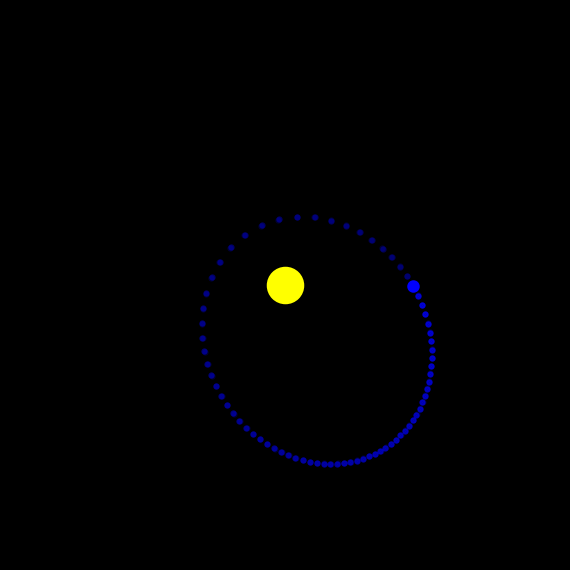

In [57]:
plot_orbits(data_T)

In [58]:
def plot_temperature(data):
    fig, ax = plt.subplots(dpi=dpi)
    ax.plot(data.t/year, (data.Earth.T*u.K).to(u.Celsius, equivalencies=u.temperature()), c="C3", label="Temperature")
    ax.plot(-2., 0., label="Earth-Sun distance", c="C0")
    ax.set_xlabel("Time [years]")
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlim(data.t[0]/year, data.t[-1]/year)
    ax.set_ylim(-100., 150.)
    axr = ax.twinx()
    axr.plot(data.t/year, data.Earth.d/AU, c="C0")
    axr.set_ylabel("Distance [AU]")
    axr.set_ylim(0., 2.0)
    ax.legend()
    fig.tight_layout()

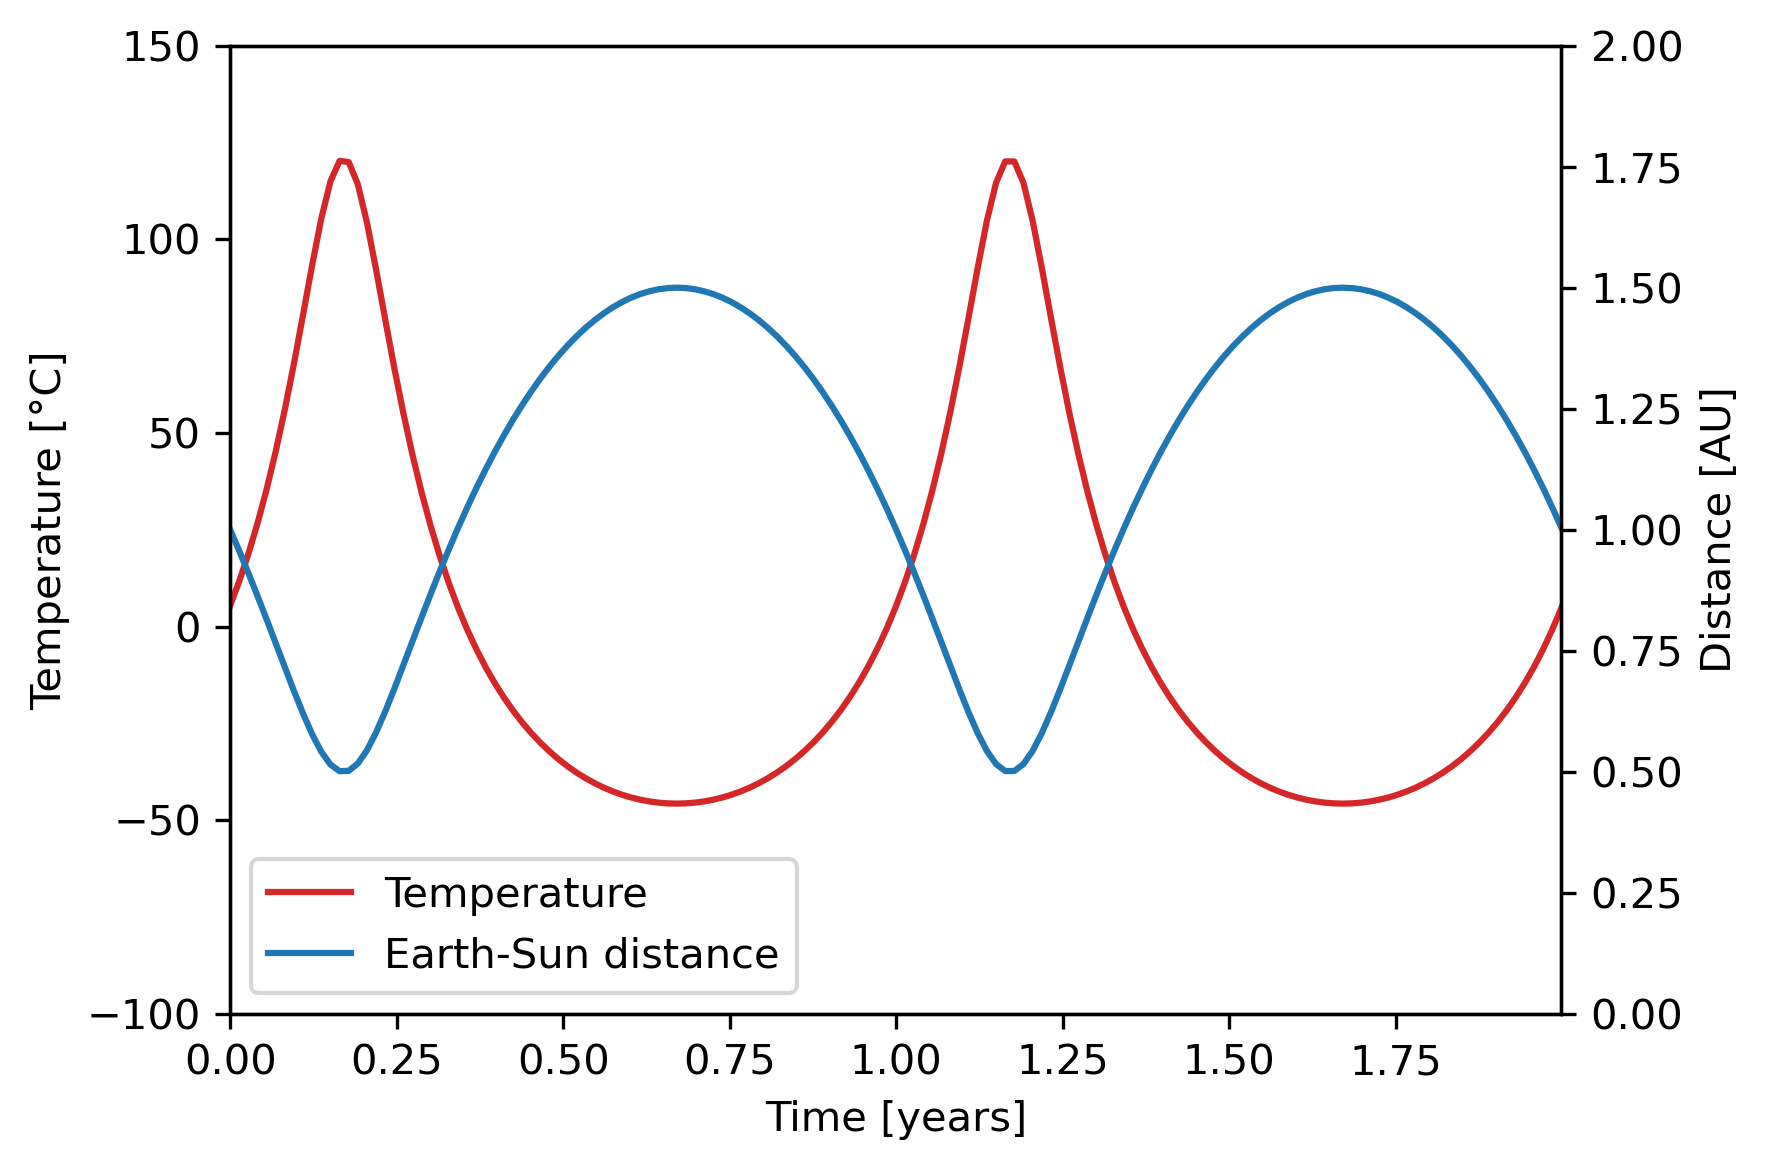

In [59]:
plot_temperature(data_T)